# Grab USDA county-level corn data from the API server.

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

api_key = '210BA222-FC6E-3FB2-B4D7-DA2DAA1CC829'

In [2]:
state_alphas = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
                "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
                "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
                "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
                "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

needless_info = ["CV (%)", "agg_level_desc", "asd_desc", "begin_code",
                 "class_desc", "commodity_desc", "congr_district_code",
                 "country_code", "country_name", "domain_desc",
                 "domaincat_desc", "end_code", "freq_desc", "group_desc",
                 "load_time", "location_desc", "prodn_practice_desc",
                 "reference_period_desc", "region_desc", "sector_desc",
                 "short_desc", "source_desc", "statisticcat_desc", "unit_desc",
                 "util_practice_desc", "watershed_code", "watershed_desc",
                 "week_ending", "zip_5", "county_ansi", "state_ansi"]


def get_corn(states, yields=True):
    """
    Grabs county-level corn data from USDA API.
    Input: states = list of U.S. state codes
           yields = boolean, if True return yields in bushels/acre, else return area in acres
    Output: pandas dataframe
    """
    data = pd.DataFrame()
    for state in states:
        print("Now grabbing: " + state)
        if yields:
            dat = requests.get("http://quickstats.nass.usda.gov/api/api_GET/?key=" + api_key + "&source_desc=SURVEY&sector_desc=CROPS&group_desc=FIELD CROPS&commodity_desc=CORN&statisticcat_desc=YIELD&util_practice_desc=GRAIN&unit_desc=BU / ACRE&agg_level_desc=COUNTY&year__GE=1950&state_alpha=" + state)
        else:
            dat = requests.get("http://quickstats.nass.usda.gov/api/api_GET/?key=" + api_key + "&source_desc=SURVEY&sector_desc=CROPS&group_desc=FIELD CROPS&commodity_desc=CORN&statisticcat_desc=AREA HARVESTED&util_practice_desc=GRAIN&unit_desc=ACRES&agg_level_desc=COUNTY&year__GE=1950&state_alpha=" + state)
        if dat.status_code == 200:
            print("Data grabbed from USDA successfully...")
            dat = dat.json()
            dat = pd.DataFrame(dat["data"])
            data = pd.concat([data, dat], ignore_index=True)
            print("Filled!")
        else:
            print("Data grabbed from USDA unsuccessfully. Error code "
                  + str(dat.status_code) + ". Skipping.")
    return data.drop(columns=needless_info)

In [3]:
# Get data
usda_county_yield = get_corn(state_alphas)
print('\n\n\n Now for the areas...\n\n\n')
usda_county_area = get_corn(state_alphas, yields=False)

Now grabbing: AL
Data grabbed from USDA successfully...
Filled!
Now grabbing: AK
Data grabbed from USDA unsuccessfully. Error code 400. Skipping.
Now grabbing: AZ
Data grabbed from USDA successfully...
Filled!
Now grabbing: AR
Data grabbed from USDA successfully...
Filled!
Now grabbing: CA
Data grabbed from USDA successfully...
Filled!
Now grabbing: CO
Data grabbed from USDA successfully...
Filled!
Now grabbing: CT
Data grabbed from USDA unsuccessfully. Error code 400. Skipping.
Now grabbing: DE
Data grabbed from USDA successfully...
Filled!
Now grabbing: FL
Data grabbed from USDA successfully...
Filled!
Now grabbing: GA
Data grabbed from USDA successfully...
Filled!
Now grabbing: HI
Data grabbed from USDA unsuccessfully. Error code 400. Skipping.
Now grabbing: ID
Data grabbed from USDA successfully...
Filled!
Now grabbing: IL
Data grabbed from USDA successfully...
Filled!
Now grabbing: IN
Data grabbed from USDA successfully...
Filled!
Now grabbing: IA
Data grabbed from USDA successful

In [4]:
# Get list of counties from USDA file
counties = pd.read_csv("./input/county_district_list.csv")
counties = counties.query('Use == 1.0')
counties = counties.query('District != 0')
counties = counties.query('Name != "State Total"')
counties["State"] = counties["State"].astype(str).str.zfill(2)
counties["County"] = counties["County"].astype(str).str.zfill(3)
counties["District"] = counties["District"].astype(str).str.zfill(2)
counties["GEOID"] = counties["State"] + counties["County"] + counties["District"]

# Get list of county code changes from USDA file
counties_to_change = pd.read_csv("./input/counties_old.csv")

counties_to_change["State"] = counties_to_change["State"].astype(str).str.zfill(2)
counties_to_change["County"] = counties_to_change["County"].astype(str).str.zfill(3)
counties_to_change["District"] = counties_to_change["District"].astype(str).str.zfill(2)
counties_to_change["GEOID"] = counties_to_change["State"] + counties_to_change["County"] + counties_to_change["District"]

counties_to_change["State_new"] = counties_to_change["State_new"].astype(str).str.zfill(2)
counties_to_change["County_new"] = counties_to_change["County_new"].astype(str).str.zfill(3)
counties_to_change["District_new"] = counties_to_change["District_new"].astype(str).str.zfill(2)
counties_to_change["GEOID_new"] = counties_to_change["State_new"] + counties_to_change["County_new"] + counties_to_change["District_new"]

In [5]:
# Process USDA county results
usda_county_yield["GEOID"] = usda_county_yield["state_fips_code"] + usda_county_yield["county_code"] + usda_county_yield["asd_code"]
usda_county_yield = usda_county_yield.rename(columns={"Value": "yield"})

usda_county_area["GEOID"] = usda_county_area["state_fips_code"] + usda_county_area["county_code"] + usda_county_area["asd_code"]
usda_county_area = usda_county_area.rename(columns={"Value": "area"})

# Merge into one df
usda_all = pd.merge(usda_county_yield.query("county_name != 'OTHER (COMBINED) COUNTIES'"), usda_county_area.query("county_name != 'OTHER (COMBINED) COUNTIES'"), how="outer", on=["GEOID", "state_fips_code", "county_code", "asd_code", "year", "county_name", "state_name", "state_alpha"])
usda_all["GEOID_new"] = usda_all["GEOID"]
usda_all.set_index(["GEOID"], inplace=True)

In [6]:
# Update old GEOIDs to current
for index, row in counties_to_change.iterrows():
    if row["GEOID_new"] != "0000000":
        if row["GEOID"] in usda_all.index:
            usda_all.loc[row["GEOID"],"GEOID_new"] = row["GEOID_new"]

In [7]:
# Update indexing
usda_all = usda_all.reset_index()
usda_all["GEOID"] = usda_all["GEOID_new"]
usda_all.drop(columns=["GEOID_new", "state_name"], inplace=True)

In [8]:
# Build index structure for final dataframe (including years)
unique_geoids = counties["GEOID"].unique()
years = np.arange(1950, 2019, 1)

unique_geoids = [[unique_geoid]*len(years) for unique_geoid in unique_geoids]
unique_geoids = np.ndarray.flatten(np.asarray(unique_geoids))

years = [years] * len(unique_geoids)
years = np.ndarray.flatten(np.asarray(years))

tuples = list(zip(*[unique_geoids, years]))

index = pd.MultiIndex.from_tuples(tuples)

In [9]:
# Build empty dataframe with complete indexing
all_index = pd.DataFrame(index = index)
all_index.index.names = ["GEOID", "year"]

# Merge yields so that empty county/year pairings are "NaN"
usda_all_indexed = pd.merge(all_index, usda_all, on = ["GEOID", "year"],  how = "outer")

# Set correct indexing
usda_all_indexed.set_index(["GEOID", "year"], inplace = True)
usda_all_indexed.sort_index(inplace = True)
usda_all_indexed = usda_all_indexed.fillna(0.0)

In [10]:
# Save
usda_all_indexed['yield'] = usda_all_indexed['yield'].astype(float)
usda_all_indexed.to_csv("./output/USDA_county_yields.csv")

# Fit county-level trends to USDA data

In [11]:
# Add logs
usda_all_indexed["log_yield"] = usda_all_indexed.apply(lambda x: np.log(x["yield"]) if x["yield"] > 0.0 else np.nan, axis = 1)

In [12]:
usda_all_indexed

asd_code county_name  yield state_alpha state_fips_code  \
GEOID   year                                                           
0100140 1950       50     AUTAUGA   17.0          AL              01   
        1951       50     AUTAUGA   13.0          AL              01   
        1952       50     AUTAUGA    9.0          AL              01   
        1953       50     AUTAUGA   20.0          AL              01   
        1954       50     AUTAUGA   11.0          AL              01   
...               ...         ...    ...         ...             ...   
5604520 2014        0           0    0.0           0               0   
        2015        0           0    0.0           0               0   
        2016        0           0    0.0           0               0   
        2017        0           0    0.0           0               0   
        2018        0           0    0.0           0               0   

             county_code    area  log_yield  
GEOID   year                                 
0100140 1950         001  29,600   2.833213  
        1951         001  29,100   2.564949  
        1952         001  24,400   2.197225  
        1953         001  24,400   2.995732  
        1954         001  24,400   2.397895  
...                  ...     ...        ...  
5604520 2014           0       0        NaN  
        2015           0       0        NaN  
        2016           0       0        NaN  
        2017           0       0        NaN  
        2018           0       0        NaN  

[324435 rows x 8 columns]

In [13]:
# Do quadratic fit (this throws up more than a few Polyfit warnings)
usda_all_indexed.dropna(inplace=True)
quad_index = pd.DataFrame()

for geoid in usda_all_indexed.index.unique(level = "GEOID"):

    data = usda_all_indexed.loc[geoid]
    years = data.index.to_numpy()

    z = np.polyfit(years, data['log_yield'], 2)
    p = np.poly1d(z)

    temp = pd.DataFrame(data = {"quad_fit" : pd.Series(p(years), index = pd.MultiIndex.from_arrays([[geoid]*len(years), years]))})
    temp.index.names = ["GEOID", "year"]
    
    quad_index = quad_index.append(temp)
    
usda_all_indexed = pd.merge(usda_all_indexed, quad_index, on = ["GEOID", "year"], how = "outer")

/Users/davidlafferty/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/davidlafferty/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/davidlafferty/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/davidlafferty/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/davidlafferty/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/davidlaf

In [14]:
# Get anomalies
usda_all_indexed["yield_anom"] = usda_all_indexed["log_yield"] - usda_all_indexed["quad_fit"]

In [15]:
usda_all_indexed

asd_code county_name  yield state_alpha state_fips_code  \
GEOID   year                                                           
0100140 1950       50     AUTAUGA   17.0          AL              01   
        1951       50     AUTAUGA   13.0          AL              01   
        1952       50     AUTAUGA    9.0          AL              01   
        1953       50     AUTAUGA   20.0          AL              01   
        1954       50     AUTAUGA   11.0          AL              01   
...               ...         ...    ...         ...             ...   
5604520 1986       20      WESTON   95.0          WY              56   
        1986       20      WESTON   95.0          WY              56   
        1986       20      WESTON   95.0          WY              56   
        1986       20      WESTON   95.0          WY              56   
        1986       20      WESTON   95.0          WY              56   

             county_code    area  log_yield  quad_fit  yield_anom  
GEOID   year                                                       
0100140 1950         001  29,600   2.833213  2.986427   -0.153214  
        1951         001  29,100   2.564949  3.005359   -0.440410  
        1952         001  24,400   2.197225  3.024518   -0.827294  
        1953         001  24,400   2.995732  3.043904   -0.048171  
        1954         001  24,400   2.397895  3.063516   -0.665620  
...                  ...     ...        ...       ...         ...  
5604520 1986         045     100   4.553877  4.337998    0.215879  
        1986         045     100   4.553877  4.337998    0.215879  
        1986         045     100   4.553877  4.337998    0.215879  
        1986         045     100   4.553877  4.337998    0.215879  
        1986         045     100   4.553877  4.337998    0.215879  

[1120101 rows x 10 columns]

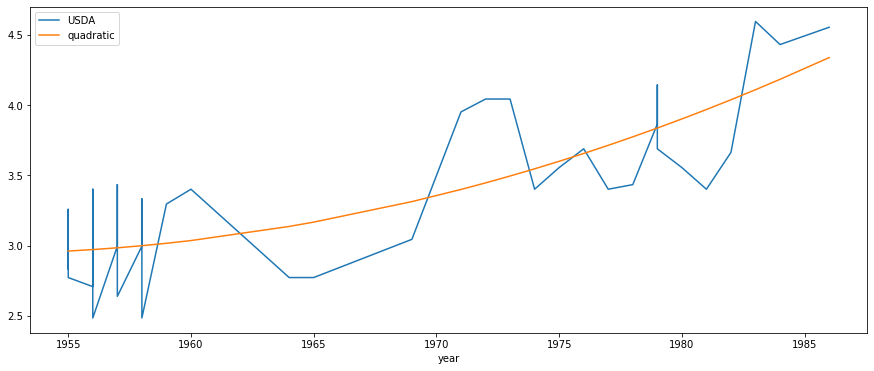

In [16]:
# Check
fig, ax = plt.subplots(figsize = (15,6))
usda_all_indexed.loc['5604520'].plot(y = "log_yield", ax = ax, label = "USDA")
usda_all_indexed.loc['5604520'].plot(y = "quad_fit", ax = ax, label = "quadratic")
plt.legend()
plt.show()

In [17]:
# Save
usda_all_indexed.to_csv("./output/USDA_county_yields_w_county_quad_trends.csv")